In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    def size(self):
        return len(self.buffer)


In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
class DQN:
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,\
            epsilon,target_update,device,dqn_type='DQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.target_q_net = Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.dqn_type = 'DQN'

        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)

        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float32).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self,transition_dict):
        states = torch.tensor(transition_dict['state'],dtype=torch.float32).to(self.device)
        actions = torch.tensor(transition_dict['action'],dtype=torch.long).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['reward'],dtype=torch.float32).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_state'],dtype=torch.float32).to(self.device)
        dones = torch.tensor(transition_dict['done'],dtype=torch.float32).view(-1,1).to(self.device)

        q_values = self.q_net(states).gather(1,actions)
        if self.dqn_type == 'DQN':
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)
        elif self.dqn_type == 'DoubleDQN':
            max_next_action = self.q_net(next_states).argmax(1).view(-1,1)
            max_next_q_values = self.target_q_net(next_states).gather(1,max_next_action)

        q_targets = rewards + self.gamma * max_next_q_values * (1-dones)

        dqn_loss = torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1


In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device)

return_list = []

for i in range(10):
    with tqdm(total=int(num_episodes/10),desc='Iteration {}'.format(i+1)) as pbar:
        for episode in range(int(num_episodes/10)):
            state = env.reset()[0]
            done = False
            episode_return = 0
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                episode_return += reward
                state = next_state
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'state': b_s, 'action': b_a, 'reward': b_r, 'next_state': b_ns, 'done': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (episode+1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes/10 * i + episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


/home/zengziyu/mntzzy/anaconda3/envs/anyscale-academy/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/zengziyu/mntzzy/anaconda3/envs/anyscale-academy/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 1:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_1341497/3630411938.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consi

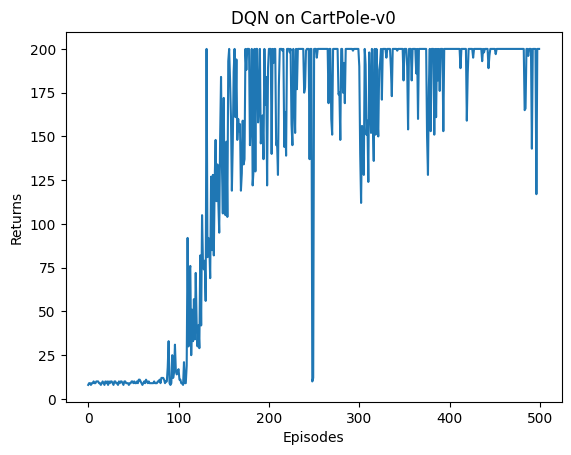

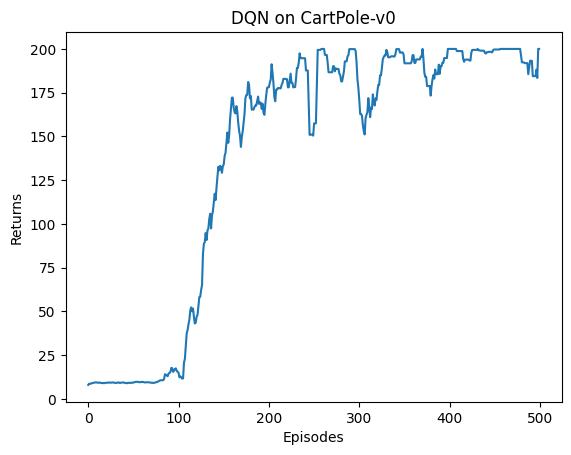

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [7]:
# without double Q-net
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 1
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device)

return_list = []

for i in range(10):
    with tqdm(total=int(num_episodes/10),desc='Iteration {}'.format(i+1)) as pbar:
        for episode in range(int(num_episodes/10)):
            state = env.reset()[0]
            done = False
            episode_return = 0
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                episode_return += reward
                state = next_state
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'state': b_s, 'action': b_a, 'reward': b_r, 'next_state': b_ns, 'done': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (episode+1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes/10 * i + episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


/home/zengziyu/mntzzy/anaconda3/envs/anyscale-academy/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 10: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s, episode=500, return=200.000]


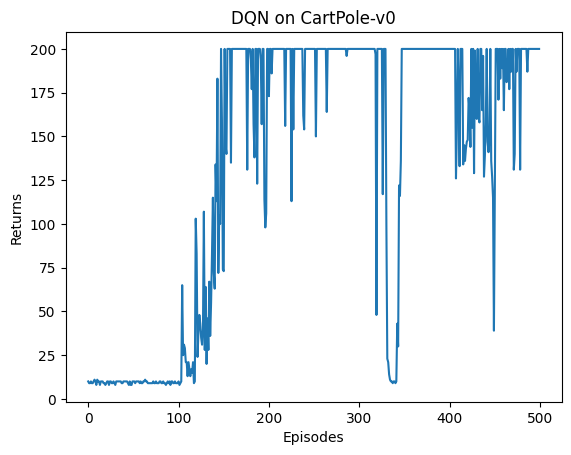

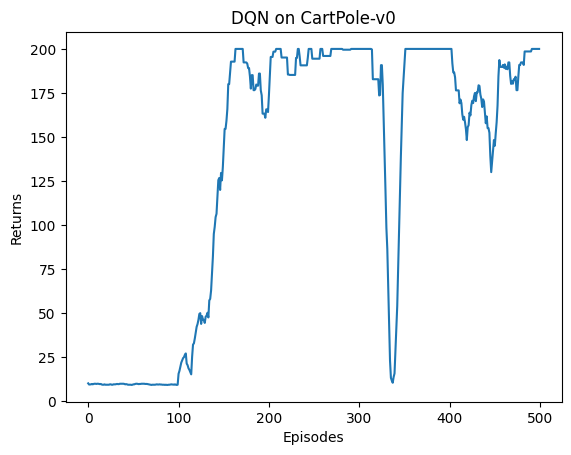

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [9]:
# Double DQN
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device,dqn_type='DoubleDQN')

return_list = []

for i in range(10):
    with tqdm(total=int(num_episodes/10),desc='Iteration {}'.format(i+1)) as pbar:
        for episode in range(int(num_episodes/10)):
            state = env.reset()[0]
            done = False
            episode_return = 0
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                episode_return += reward
                state = next_state
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'state': b_s, 'action': b_a, 'reward': b_r, 'next_state': b_ns, 'done': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (episode+1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes/10 * i + episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


Iteration 10: 100%|██████████| 50/50 [03:15<00:00,  3.91s/it, episode=500, return=200.000]


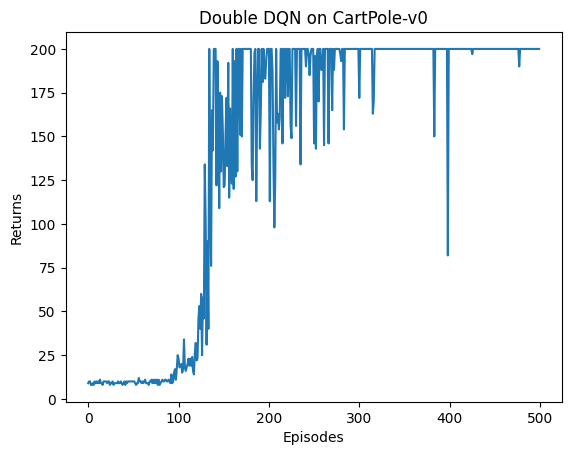

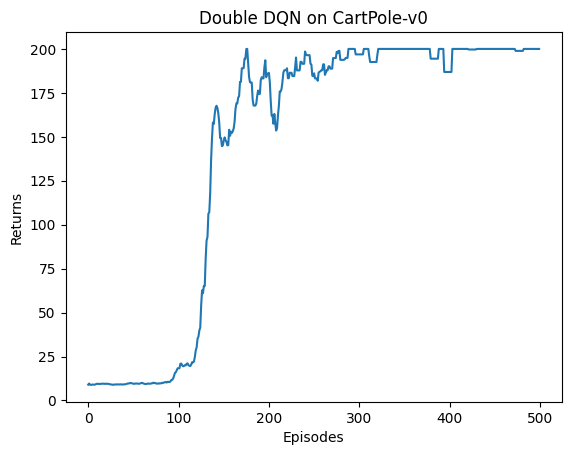

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()